# Stock Market Analysis

This notebook performs a clean, simple, and well-documented analysis of a stock market dataset (stocks.csv).
It is intended for an internship project: concise EDA, visualizations, feature engineering, and a baseline prediction model.

**What to expect**:
- Data loading & cleaning
- Exploratory data analysis (price trends, volume, moving averages)
- Returns & volatility
- Feature engineering (lags, rolling stats)
- Baseline Linear Regression prediction for next-day Close price


In [1]:
# Imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
sns.set_style('whitegrid')


In [3]:
# Load data
df = pd.read_csv(r'C:\Users\vanis\Downloads\stock market project\dataset\stocks.csv')
# Try to parse Date column if present
date_cols = [c for c in df.columns if 'date' in c.lower()]
if date_cols:
    df['Date'] = pd.to_datetime(df[date_cols[0]])
elif 'Date' in df.columns or 'date' in df.columns:
    df['Date'] = pd.to_datetime(df.get('Date', df.get('date')))
else:
    # try common formats: if first column looks like a date, parse it
    try:
        df['Date'] = pd.to_datetime(df.iloc[:,0])
    except Exception as e:
        print('No date column detected automatically:', e)

# If Date exists, sort and set as index
if 'Date' in df.columns:
    df = df.sort_values('Date').reset_index(drop=True)
    df.set_index('Date', inplace=True)

df.head()

,Ticker,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2023-02-07,AAPL,150.639999,155.229996,150.639999,154.649994,154.414230,83322600
2023-02-07,MSFT,260.529999,268.769989,260.079987,267.559998,266.891510,50841400
2023-02-07,GOOG,103.629997,108.669998,103.547997,108.040001,108.040001,33738800
2023-02-07,NFLX,358.510010,364.179993,354.179993,362.950012,362.950012,6289400
2023-02-08,GOOG,102.690002,103.580002,98.455002,100.000000,100.000000,73546000


In [4]:
# Basic info and cleaning
print('Shape:', df.shape)
print('Columns:', df.columns.tolist())
# Convert numeric columns
for col in df.columns:
    if df[col].dtype == 'object':
        # remove commas and try to convert
        try:
            df[col] = df[col].str.replace(',', '').astype(float)
        except:
            pass

df = df.apply(pd.to_numeric, errors='ignore')
df.isnull().sum()

Shape: (248, 7)
Columns: ['Ticker', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


Ticker       0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

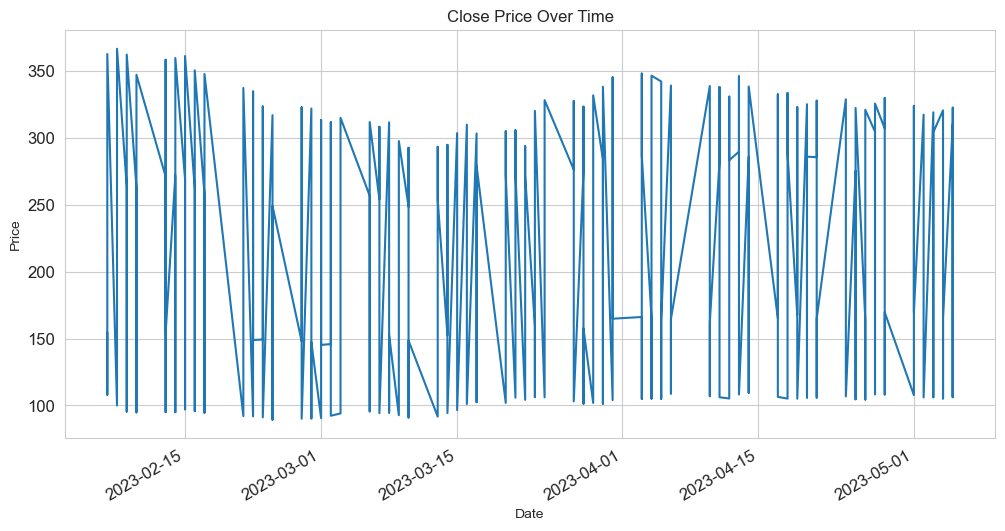

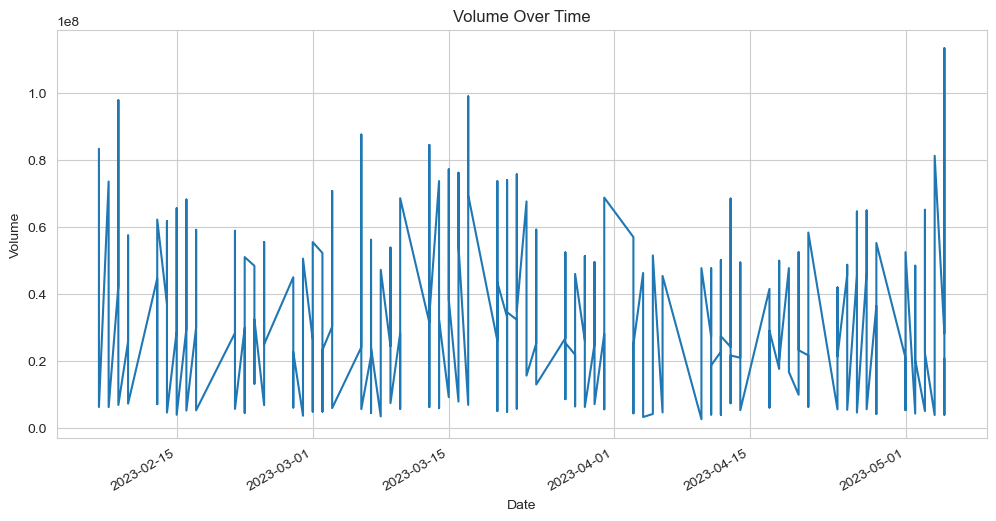

In [5]:
# Plot Close price and Volume (if present)
if 'Close' in df.columns:
    df['Close'].plot(title='Close Price Over Time', fontsize=12)
    plt.ylabel('Price')
    plt.show()
else:
    print('Close column not found. Available columns:', df.columns.tolist())

if 'Volume' in df.columns:
    df['Volume'].plot(title='Volume Over Time')
    plt.ylabel('Volume')
    plt.show()

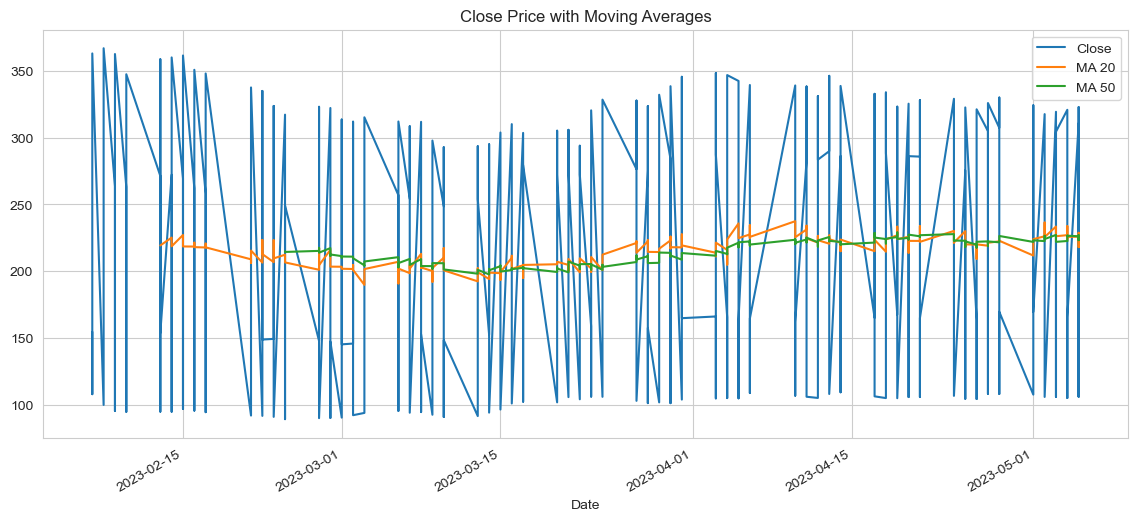

In [6]:
# Moving averages
if 'Close' in df.columns:
    df['MA_20'] = df['Close'].rolling(window=20).mean()
    df['MA_50'] = df['Close'].rolling(window=50).mean()

    plt.figure(figsize=(14,6))
    df['Close'].plot(label='Close')
    df['MA_20'].plot(label='MA 20')
    df['MA_50'].plot(label='MA 50')
    plt.legend()
    plt.title('Close Price with Moving Averages')
    plt.show()
else:
    print('Close column missing, skipping moving averages')

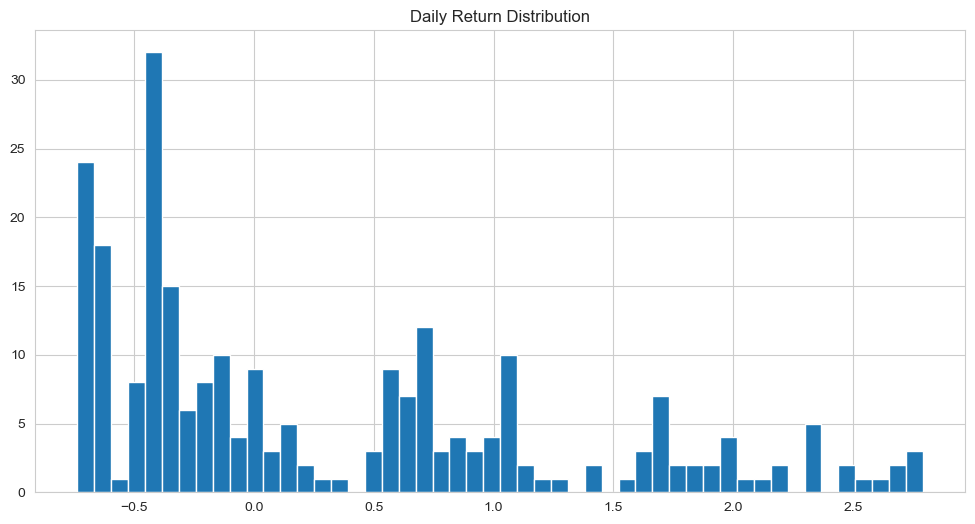

Mean return: 0.3142508589591466
Std dev (volatility): 0.9584126443596677


In [7]:
# Daily Returns and distribution
if 'Close' in df.columns:
    df['Return'] = df['Close'].pct_change()
    df['Return'].hist(bins=50)
    plt.title('Daily Return Distribution')
    plt.show()

    print('Mean return:', df['Return'].mean())
    print('Std dev (volatility):', df['Return'].std())
else:
    print('Close missing')

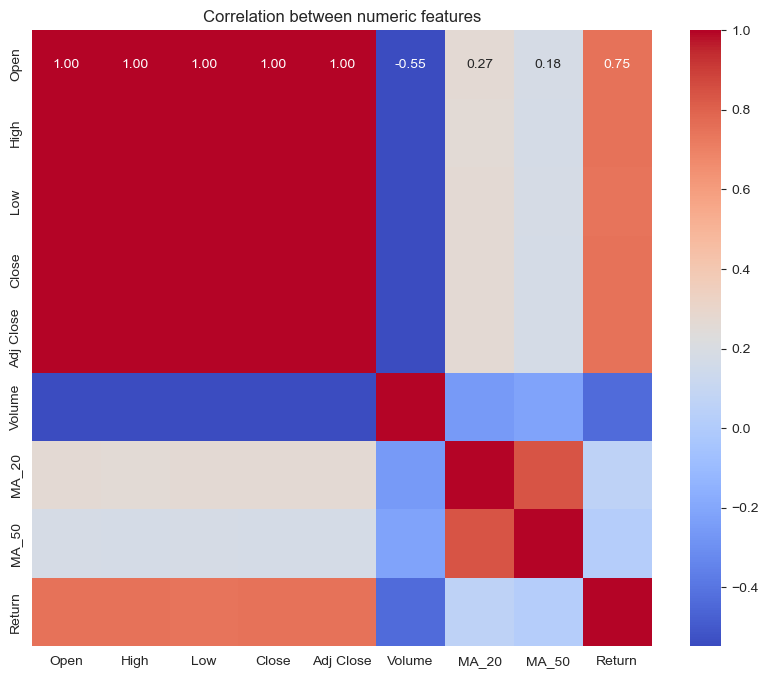

In [8]:
# Correlation heatmap
num = df.select_dtypes(include=[np.number])
if not num.empty:
    plt.figure(figsize=(10,8))
    sns.heatmap(num.corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation between numeric features')
    plt.show()
else:
    print('No numeric columns to correlate')

In [9]:
# Feature engineering for baseline model (predict next-day Close)
if 'Close' in df.columns:
    data = df[['Close']].copy()
    # Create lag features
    data['Close_lag1'] = data['Close'].shift(1)
    data['Close_lag2'] = data['Close'].shift(2)
    data['MA_7'] = data['Close'].rolling(window=7).mean().shift(1)
    data['MA_21'] = data['Close'].rolling(window=21).mean().shift(1)
    data['Return_1'] = data['Close'].pct_change().shift(1)
    data = data.dropna()

    # Target is next-day Close -> shift -1 so each row predicts next day
    data['Target'] = data['Close'].shift(-1)
    data = data.dropna()

    X = data.drop('Target', axis=1)
    y = data['Target']

    # Train-test split in time-series aware way (no shuffle)
    split = int(0.8 * len(data))
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]
    print('Training rows:', len(X_train), 'Testing rows:', len(X_test))
else:
    print('Close column missing - cannot create model features')

Training rows: 180 Testing rows: 46


MAE: 72.6616
RMSE: 83.0988


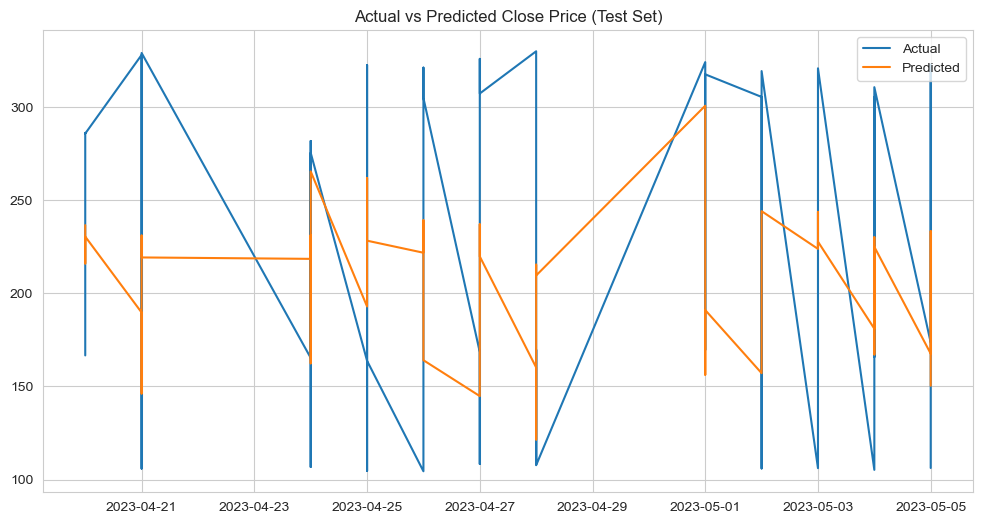

In [10]:
# Baseline Linear Regression model
if 'Close' in df.columns:
    model = LinearRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared=False)

    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')

    # plot predictions vs actual
    plt.figure(figsize=(12,6))
    plt.plot(y_test.index, y_test.values, label='Actual')
    plt.plot(y_test.index, preds, label='Predicted')
    plt.legend()
    plt.title('Actual vs Predicted Close Price (Test Set)')
    plt.show()
else:
    print('Close column missing - skipping model')